In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('classic')
from sklearn.decomposition import PCA
from cond_color import get_colors, plot_start, plot_end

In [2]:
np.random.seed(42)

Loading Data

In [3]:
data_orig = np.load('psths.npz')
X, times = data_orig['X'], data_orig['times']

# Exercise 1: Plotting raw PSTHs

In [4]:
def plot_psths(data, timeintervals, n_rows, n_cols, n_cond):
    np.random.seed(42)
    cond = np.random.randint(low=data.shape[1], size=n_cond)

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(15,10))

    for row in ax:
        for col in row:
            n = np.random.randint(low=data.shape[0], size=1)[0]

            for c in cond:
                col.plot(timeintervals, data[n, c,:], label = 'C = '+str(c))
                col.set_title(f'Neuron {n}')
                col.legend()
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel('Time relative to onset of hand movement')
    plt.ylabel('Trial-averaged spike rate (Hz)')

    plt.show()
    return

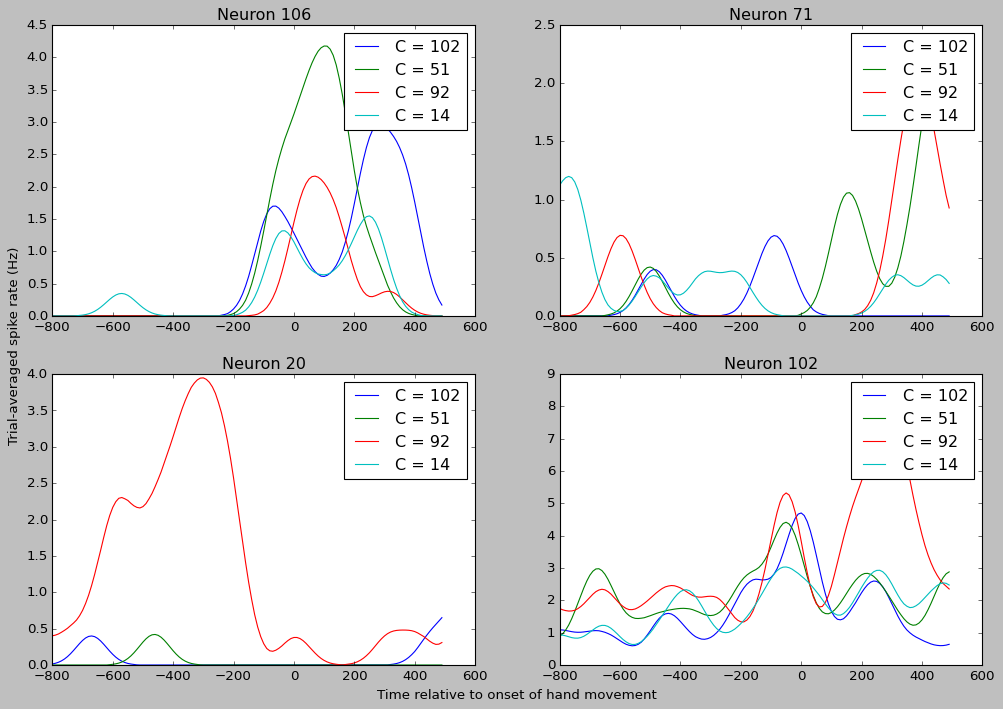

In [5]:
plot_psths(X, times, 2, 2, 4)

# Exercise 2: Pre-processing

## Normalisation

In [6]:
a, b = X.max(axis=(1,2)), X.min(axis=(1,2))
a, b = a.reshape(182,1,1), b.reshape(182,1,1)

X_norm = (X - b) / (a - b + 5 )

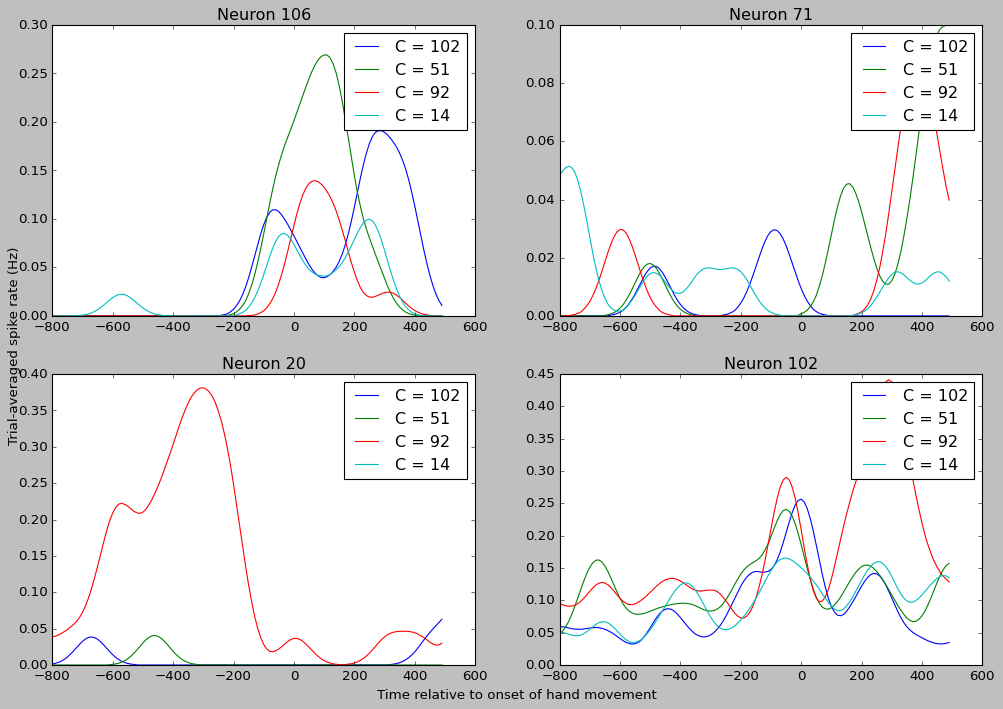

In [7]:
plot_psths(X_norm, times, 2, 2, 4)

## Mean centering

In [8]:
mean = X_norm.mean(axis=(0,2))
print(mean.shape)
mean = mean.reshape(1, 108, 1)
X_norm_mean = X_norm - mean

(108,)


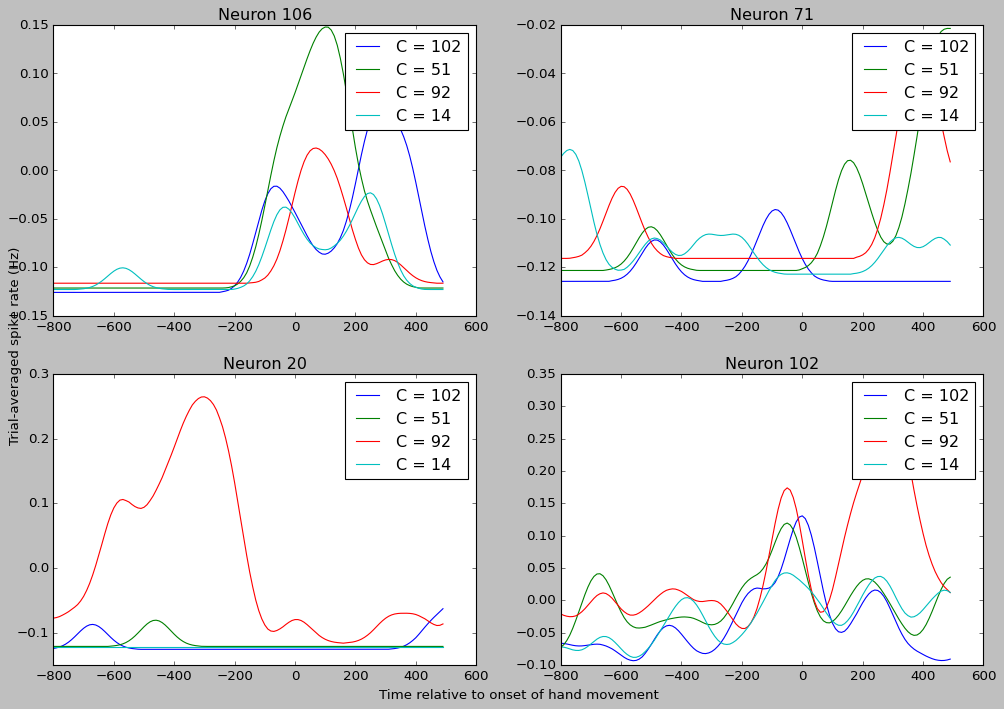

In [9]:
plot_psths(X_norm_mean, times, 2, 2, 4)

## Dimensionality reduction by PCA

In [10]:
times = times[65:111]

In [11]:
X_trunc = X_norm_mean[:,:,65:111]
X = X_trunc.reshape(X_trunc.shape[0], X_trunc.shape[1]*X_trunc.shape[2])
print(X.shape)

(182, 4968)


In [12]:
pca = PCA(n_components=12)
pca.fit(X.T)
Z = pca.transform(X.T).T
print(Z.shape)

(12, 4968)


# Plotting PC space trajectorie

In [13]:
Z = Z.reshape(12, X_trunc.shape[1], X_trunc.shape[2])

In [14]:
def plot_pca_psths(data, pca_axis_1, pca_axis_2):
    np.random.seed(42)
    pca_axis_1 -= 1
    pca_axis_2 -= 1

    colors = get_colors(data[pca_axis_1, :, -1], data[pca_axis_2, :, -1], False)
    for cond in range(0, data.shape[1]):
        plt.plot(X[pca_axis_1, cond, :], X[pca_axis_2, cond, :], label = 'C = '+str(cond), color=colors[cond])
        plt.title(f'PCA plot')
        plt.xlabel(f'PCA - {pca_axis_1 + 1}')
        plt.ylabel(f'PCA - {pca_axis_2 + 1}')
    plot_start(data[pca_axis_1, :, 0], data[pca_axis_2, :, 0], colors, markersize=50, ax=None)
    plot_end(data[pca_axis_1, :, -1], data[pca_axis_2, :, -1], colors, markersize=50, ax=None)

    plt.show()
    return

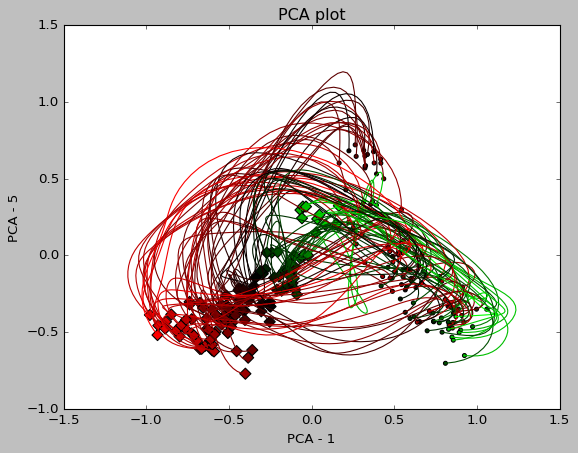

In [15]:
plot_pca_psths(Z, 1, 5)

# Exercise 4: Finding the max. likelihood estimate for A

## Log-likelihood and its (naive) gradient

$\Delta z_{t+1} = Az_{t} + \sigma \epsilon_t$ where $\sigma=1$

$\Delta z_{t+1} = N(Az_{t},I_{12\times12})$

$P(\Delta z_{1:T} | z_{0:T}) = \prod^T_{t=0}N(Az_{t},I_{12\times12})$

$log(P(\Delta z_{1:T} | z_{0:T})) = \sum^T_{t=0}log(N(Az_{t},I_{12\times12}))$

$log(P(\Delta z_{1:T} | z_{0:T})) \propto \sum^T_{t=0} log(\exp(-(\Delta z_{t+1} - Az_{t})^TI_{12\times12}(\Delta z_{t+1} - Az_{t})))$

$log(P(\Delta z_{1:T} | z_{0:T})) \propto -\sum^T_{t=0} (\Delta z_{t+1} - Az_{t})^TI_{12\times12}(\Delta z_{t+1} - Az_{t})$

$log(P(\Delta Z | Z)) \propto -(\Delta Z - AZ)^T(\Delta Z - AZ) \approx  - Z^TA^TAZ + 2\Delta Z^T A Z$

$\frac{d}{dA}(log(P(\Delta Z | Z))) = -2 Z^TA^TZ + 2\Delta Z^T  Z$

$A = \Delta Z Z^{-1}$

##  Parametrising an antisymmetric (NOT FINISHED)

K will equal 6, as each row must be a unit vector within a rotational matrix. Of course this is relaxed abit with our first-order approximation.

In [49]:
beta = [[0.0001,0.0002]]
H = [[[0., 0., 0., -1.],
      [0., 0., 0. ,0.],
      [0., 0. ,0., 0.],
      [1., 0. ,0., 0.],
      [0., 0. ,0., 0.],
      [0., 0. ,0., 0.],
      [0., 0. ,0., 0.],
      [0. ,0., 0. ,0.]],

     [[0., 0., 0., 0.],
      [0., 0., -1. ,0.],
      [0., 1. ,0., 0.],
      [0., 0. ,0., 0.],
      [0., 0. ,0., 0.],
      [0., 0. ,0., 0.],
      [0., 0. ,0., 0.],
      [0. ,0., 0. ,0.]]]

A = np.tensordot(beta, H, axes=1).sum(axis=0)
print(A)

[[ 0.      0.      0.     -0.0001]
 [ 0.      0.     -0.0002  0.    ]
 [ 0.      0.0002  0.      0.    ]
 [ 0.0001  0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.    ]]


# Gradient with respect to β

$log(P(\Delta Z | Z)) \approx  - (\sum^K_{a=1}\beta_a \sum^M_{j=1}H_{a,i,j}Z_{j,n})^T(\sum^K_{a=1}\beta_a\sum^M_{j=1}H_{a,i,j}Z_{j,n}) + 2\Delta Z^T (\sum^K_{a=1}\beta_a\sum^M_{j=1}H_{a,i,j}Z_{j,n})$

$\frac{d}{d\beta}(log(P(\Delta Z | Z))) \approx -2 (\sum^K_{a=1}\beta_a \sum^M_{j=1}H_{a,i,j}Z_{j,n})^T(\sum^K_{a=1}\sum^M_{j=1}H_{a,i,j}Z_{j,n}) + 2\Delta Z^T (\sum^K_{a=1}\sum^M_{j=1}H_{a,i,j}Z_{j,n})$

$\frac{d}{d\beta}(log(P(\Delta Z | Z))) \approx  2\Delta Z^T \sum^K_{a=1}W_{a,i,n}
-2 (\sum^K_{a=1}\beta_a W_{a,i,n})^T(\sum^K_{a=1}W_{a,i,n})$

$\sum^K_{a=1}\beta_a W_{a,i,n} =
 (\frac{\Delta Z^T\sum^K_{a=1} (W_{a,i,n})}{\sum^K_{a=1}W_{a,i,n}})^T$